In [2]:
import os
import sys

BASE_DIR = os.path.expanduser("~/Desktop/gray_ambulance_ml")
DATA_PATH = os.path.join(BASE_DIR, "data", "raw", "synthetic_vitals.csv")
SRC_PATH = os.path.join(BASE_DIR, "src")

sys.path.append(SRC_PATH)

print("Base dir:", BASE_DIR)
print("CSV exists:", os.path.exists(DATA_PATH))


Base dir: C:\Users\a5753/Desktop/gray_ambulance_ml
CSV exists: True


In [3]:
import pandas as pd

data = pd.read_csv(DATA_PATH)
print("Dataset shape:", data.shape)

data.head()

Dataset shape: (90000, 7)


,patient_id,time_sec,heart_rate,spo2,bp_systolic,bp_diastolic,motion
0,1,0,77.483571,99.330833,113.408516,74.061174,0.313965
1,1,1,74.308678,97.957537,114.247124,78.013384,0.306502
2,1,2,78.238443,97.504115,136.398497,82.671824,0.381328
3,1,3,82.615149,96.940400,120.005463,80.455468,0.215615
4,1,4,73.829233,96.737802,126.257040,75.742300,0.125633


In [4]:
from artifact_handling import handle_artifacts

print("Artifact module imported successfully")


Artifact module imported successfully


In [54]:
patient_id = 1

patient_raw = data[data.patient_id == patient_id].reset_index(drop=True)
patient_clean = handle_artifacts(patient_raw)

patient_clean.head()

,patient_id,time_sec,heart_rate,spo2,bp_systolic,bp_diastolic,motion
0,1,0,77.483571,99.330833,113.408516,74.061174,0.313965
1,1,1,74.308678,97.957537,114.247124,78.013384,0.306502
2,1,2,78.238443,97.504115,136.398497,82.671824,0.381328
3,1,3,82.615149,96.940400,120.005463,80.455468,0.215615
4,1,4,73.829233,96.737802,126.257040,75.742300,0.125633


In [7]:
patient_id = 1
patient_raw = data[data.patient_id == patient_id].reset_index(drop=True)
patient_clean = handle_artifacts(patient_raw)


In [53]:
WINDOW = 60 

df = patient_clean.copy()

df["hr_mean"] = df["heart_rate"].rolling(WINDOW).mean()
df["hr_std"]  = df["heart_rate"].rolling(WINDOW).std()

df["spo2_mean"] = df["spo2"].rolling(WINDOW).mean()
df["spo2_std"]  = df["spo2"].rolling(WINDOW).std()

df.head()


,patient_id,time_sec,heart_rate,spo2,bp_systolic,bp_diastolic,motion,hr_mean,hr_std,spo2_mean,spo2_std
0,1,0,77.483571,99.330833,113.408516,74.061174,0.313965,NaN,NaN,NaN,NaN
1,1,1,74.308678,97.957537,114.247124,78.013384,0.306502,NaN,NaN,NaN,NaN
2,1,2,78.238443,97.504115,136.398497,82.671824,0.381328,NaN,NaN,NaN,NaN
3,1,3,82.615149,96.940400,120.005463,80.455468,0.215615,NaN,NaN,NaN,NaN
4,1,4,73.829233,96.737802,126.257040,75.742300,0.125633,NaN,NaN,NaN,NaN


In [52]:
TREND_WINDOW = 30

df["hr_trend"] = df["heart_rate"].diff(TREND_WINDOW)
df["spo2_trend"] = df["spo2"].diff(TREND_WINDOW)

df["hr_trend_flag"] = df["hr_trend"] > 10

df["spo2_trend_flag"] = df["spo2_trend"] < -3

df["trend_flag"] = df["hr_trend_flag"] | df["spo2_trend_flag"]


In [51]:
import numpy as np

df["hr_z"] = (df["heart_rate"] - df["hr_mean"]) / df["hr_std"]
df["spo2_z"] = (df["spo2"] - df["spo2_mean"]) / df["spo2_std"]

# cmb anomaly score
df["anomaly_score"] = (
    df["hr_z"].abs().fillna(0) +
    df["spo2_z"].abs().fillna(0)
)

df[["time_sec", "heart_rate", "spo2", "anomaly_score"]].head()


,time_sec,heart_rate,spo2,anomaly_score
0,0,77.483571,99.330833,0.0
1,1,74.308678,97.957537,0.0
2,2,78.238443,97.504115,0.0
3,3,82.615149,96.940400,0.0
4,4,73.829233,96.737802,0.0


In [34]:
df["anomaly_flag"] = (
    (
        df["anomaly_score"]
        .rolling(30)
        .mean()
        > ANOMALY_THRESHOLD
    )
    | df["trend_flag"]
)


In [28]:
print("Total anomaly predictions:", df["anomaly_flag"].sum())
print("True distress count:", df["true_distress_flag"].sum())
print("Overlap (TP):", ((df["true_distress_flag"] == True) & (df["anomaly_flag"] == True)).sum())


Total anomaly predictions: 118
True distress count: 181
Overlap (TP): 65


In [49]:
DISTRESS_START = 900
DISTRESS_END = 1200

df.loc[DISTRESS_START:DISTRESS_END, "heart_rate"] += np.linspace(0, 30, DISTRESS_END - DISTRESS_START + 1)
df.loc[DISTRESS_START:DISTRESS_END, "spo2"] -= np.linspace(0, 8, DISTRESS_END - DISTRESS_START + 1)

print("Distress window injected.")


Distress window injected.


In [30]:
HR_THRESHOLD = 110
SPO2_THRESHOLD = 93
PERSISTENCE = 20

df["true_distress_instant"] = (
    (df["heart_rate"] > HR_THRESHOLD) |
    (df["spo2"] < SPO2_THRESHOLD)
)

df["true_distress_flag"] = (
    df["true_distress_instant"]
    .rolling(PERSISTENCE)
    .sum()
    >= PERSISTENCE
)

df["true_distress_flag"] = df["true_distress_flag"].fillna(False)

print("New distress count:", df["true_distress_flag"].sum())


New distress count: 217


In [31]:
from sklearn.metrics import precision_score, recall_score, confusion_matrix

y_true = df["true_distress_flag"]
y_pred = df["anomaly_flag"]

precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)

tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

false_alert_rate = fp / (fp + tn)

print("Precision:", round(precision, 3))
print("Recall:", round(recall, 3))
print("False Alert Rate:", round(false_alert_rate, 3))


Precision: 0.551
Recall: 0.3
False Alert Rate: 0.033


In [35]:
import numpy as np

true_indices = np.where(df["true_distress_flag"])[0]
pred_indices = np.where(df["anomaly_flag"])[0]

if len(true_indices) > 0 and len(pred_indices) > 0:
    distress_start = true_indices[0]
    alert_trigger = pred_indices[pred_indices >= distress_start][0]
    latency = alert_trigger - distress_start
    print("Alert Latency (seconds):", latency)
else:
    print("Latency could not be computed.")


Alert Latency (seconds): 1


In [36]:
print("Max HR:", df["heart_rate"].max())
print("Min SpO2:", df["spo2"].min())
print("True distress count:", df["true_distress_flag"].sum())


Max HR: 201.72657268039362
Min SpO2: 68.20865235654465
True distress count: 217


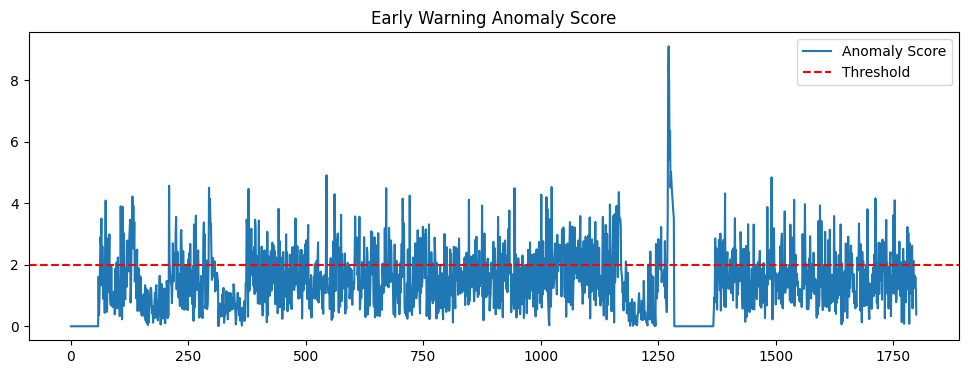

In [47]:

import matplotlib.pyplot as plt

plt.figure(figsize=(12,4))
plt.plot(df.time_sec, df.anomaly_score, label="Anomaly Score")
plt.axhline(ANOMALY_THRESHOLD, color="red", linestyle="--", label="Threshold")
plt.legend()
plt.title("Early Warning Anomaly Score")
plt.show()


In [46]:

df["anomaly_norm"] = df["anomaly_score"] / df["anomaly_score"].max()

df["spo2_trend"] = -df["spo2"].diff().rolling(30).mean()
df["hr_trend"] = df["heart_rate"].diff().rolling(30).mean()
df["risk_score"] = (
    0.5 * df["anomaly_norm"].fillna(0) +
    0.3 * df["spo2_trend"].fillna(0).clip(0, 1) +
    0.2 * df["hr_trend"].fillna(0).clip(0, 1)
)
df["risk_score"] = df["risk_score"].clip(0, 1)


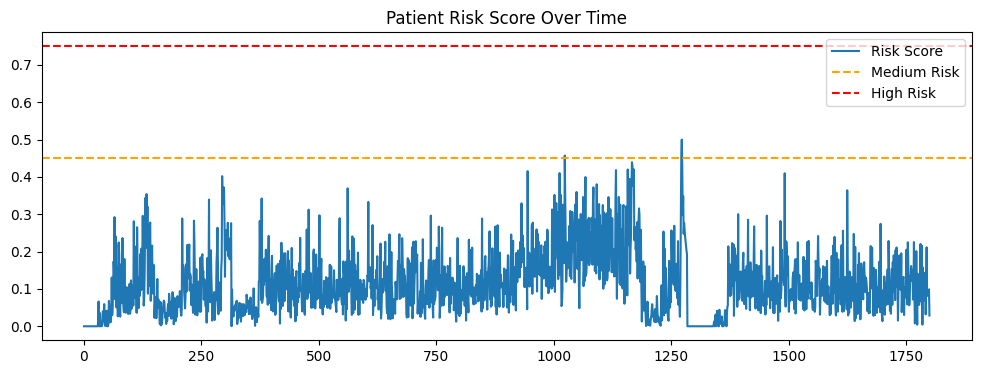

In [39]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,4))
plt.plot(df.time_sec, df.risk_score, label="Risk Score")
plt.axhline(0.45, color="orange", linestyle="--", label="Medium Risk")
plt.axhline(0.75, color="red", linestyle="--", label="High Risk")
plt.legend()
plt.title("Patient Risk Score Over Time")
plt.show()


In [20]:
pip install fastapi uvicorn


  Using cached fastapi-0.128.7-py3-none-any.whl.metadata (30 kB)
  Using cached starlette-0.52.1-py3-none-any.whl.metadata (6.3 kB)
  Using cached pydantic-2.12.5-py3-none-any.whl.metadata (90 kB)
Using cached fastapi-0.128.7-py3-none-any.whl (103 kB)
Using cached starlette-0.52.1-py3-none-any.whl (74 kB)
Using cached pydantic-2.12.5-py3-none-any.whl (463 kB)

   ---------------------------------------- 0/3 [starlette]
   ---------------------------------------- 0/3 [starlette]
   ---------------------------------------- 0/3 [starlette]
   ------------- -------------------------- 1/3 [pydantic]
   ------------- -------------------------- 1/3 [pydantic]
   ------------- -------------------------- 1/3 [pydantic]
   ------------- -------------------------- 1/3 [pydantic]
   ------------- -------------------------- 1/3 [pydantic]
   ------------- -------------------------- 1/3 [pydantic]
   ------------- -------------------------- 1/3 [pydantic]
   ------------- --------------------------

ERROR: Could not install packages due to an OSError: [WinError 2] The system cannot find the file specified: 'C:\\Python312\\Scripts\\fastapi.exe' -> 'C:\\Python312\\Scripts\\fastapi.exe.deleteme'



In [40]:
from sklearn.metrics import confusion_matrix

y_true = df["true_distress_flag"]
y_pred = df["anomaly_flag"]

tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

print("Confusion Matrix:")
print("TP:", tp)
print("FP:", fp)
print("FN:", fn)
print("TN:", tn)


Confusion Matrix:
TP: 177
FP: 213
FN: 40
TN: 1370


In [44]:
from sklearn.metrics import confusion_matrix

y_true = df["true_distress_flag"]
y_pred = df["anomaly_flag"]

cm = confusion_matrix(y_true, y_pred)

print(cm)


[[1370  213]
 [  40  177]]


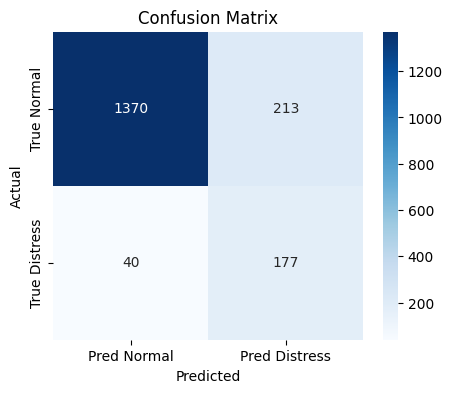

In [45]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Pred Normal", "Pred Distress"],
            yticklabels=["True Normal", "True Distress"])
plt.title("Confusion Matrix")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()


In [42]:
pip install seaborn
